In [ ]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.3'
#spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graph

In [ ]:
# First, enter the following code to download a Postgres driver that will allow Spark to interact with Postgres:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2021-08-19 21:04:13--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar.2’

postgresql-42.2.16. 100%[===================>] 979.38K  --.-KB/s    in 0.1s    

2021-08-19 21:04:13 (6.48 MB/s) - ‘postgresql-42.2.16.jar.2’ saved [1002883/1002883]



In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Final_Regression_NeuralNetwork").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [ ]:
# Load in a sql functions
# Import our dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from pyspark.sql.functions import col, avg, sum, count, rand, randn, to_timestamp, to_date, date_format, sqrt, unix_timestamp, from_unixtime
from pathlib import Path
from sklearn.linear_model import LinearRegression

In [ ]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://tq2cutebucket.s3.us-west-1.amazonaws.com/final_data.csv"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get("final_data.csv"), sep=",", header=True, inferSchema=True)

In [ ]:
# Drop null values
# This is a safety step in case the data is not perfect
df = df.dropDuplicates(['MLS_Number','Street_Address','City','Zip_Code','county','County_Index','SqFtTotal','Lot_Size','BedsTotal','BathsTotal','BathsFull','BathsHalf','Year_Built','List_Price','Sale_Price'])
df = df.sort("MLS_Number")

In [ ]:
# Process the date column (listing date and sale date)
#df.select(to_date(df.Sale_Date, 'MM/dd/yyyy HH:mm').alias('date')).show()

df = df.withColumn('Sale_Date',to_date(to_timestamp(col('Sale_Date'), 'M/d/yyyy H:mm')))
df = df.withColumn('Listing_Date',to_date(to_timestamp(col('Listing_Date'), 'M/d/yyyy H:mm')))

In [ ]:
# Convert data to pandas df
data_df=df.select('county','SqFtTotal','Lot_Size','Age','BathsTotal','BedsTotal','BathsFull','BathsHalf','DOM','Year_Sold','List_Price','Sale_Price').toPandas()

In [ ]:
# Break down county into column of county_county
application_cat = data_df.dtypes[data_df.dtypes == "object"].index.tolist()
data_df[application_cat].nunique()

county    46
dtype: int64

In [ ]:
# Look at APPLICATION_TYPE value counts for binning
#  YOUR CODE GOES HERE
# Check the unique value counts to see if binning is required
county_type_counts = data_df.county.value_counts()
county_type_counts

Los Angeles        701
Riverside          412
Orange             403
San Bernardino     282
Sacramento         281
San Diego          237
Contra Costa       237
Santa Clara        208
Alameda            181
Placer             122
San Joaquin        104
Stanislaus          94
Butte               91
San Mateo           79
Marin               75
San Luis Obispo     75
Solano              60
Ventura             53
Yuba                52
El Dorado           49
Sonoma              44
San Francisco       41
Merced              39
Monterey            37
Santa Cruz          34
Yolo                31
Sutter              29
Nevada              26
Madera              18
Lake                14
Santa Barbara       13
Napa                13
Kern                12
San Benito          11
Mendocino           10
Amador              10
Shasta               9
Fresno               9
Colusa               8
Calaveras            7
Glenn                3
Tehama               3
Tuolumne             3
Tulare     

In [ ]:
# Determine which values to replace if counts are less than ...?
# Determine which values to replaceapplication_type_counts
replace_county = list(county_type_counts[county_type_counts < 10].index)

# Replace in dataframe
for app in replace_county:
    data_df.county = data_df.county.replace(app,"Other")
    
# Check to make sure binning was successful
# data_df.county.value_counts()

In [ ]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(data_df[application_cat]))


# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
#encode_df.head()

In [ ]:
# Merge one-hot encoded features and drop the originals
data_df = data_df.merge(encode_df,left_index=True, right_index=True)
data_df = data_df.drop(application_cat,1)

In [ ]:
# Perform descriptive analytics
# This will take times and RAM resources
data_df.describe().transpose().head(10)
#data_df.columns

,count,mean,std,min,25%,50%,75%,max
SqFtTotal,4225.0,2.005063e+03,9.413365e+02,454.0,1368.0,1792.0,2383.0,13300.0
Lot_Size,4225.0,3.089252e+05,9.476886e+06,864.0,5683.0,7149.0,10063.0,493360560.0
Age,4225.0,4.465278e+01,2.580530e+01,0.0,23.0,43.0,64.0,138.0
BathsTotal,4225.0,2.480710e+00,1.010442e+00,0.0,2.0,2.0,3.0,12.0
BedsTotal,4225.0,3.438817e+00,8.884830e-01,1.0,3.0,3.0,4.0,8.0
BathsFull,4225.0,2.208757e+00,8.359631e-01,0.0,2.0,2.0,3.0,8.0
BathsHalf,4225.0,2.719527e-01,4.627524e-01,0.0,0.0,0.0,1.0,4.0
DOM,4225.0,1.036047e+01,3.052176e+01,0.0,3.0,6.0,9.0,1013.0
Year_Sold,4225.0,2.020981e+03,1.371441e-01,2020.0,2021.0,2021.0,2021.0,2021.0
List_Price,4225.0,1.014835e+06,1.119410e+06,76900.0,499000.0,715900.0,1130000.0,24999000.0


**INPUT:** need to make some decision here

In [ ]:
# Need to make some decision here, which will affect all the 4 models
test_size = 0.05 # due to sample size of 4K thousand samples
random_state = 5
hidden_nodes_layer1 = 15 # Change this number will affect both NN and NN2 models
hidden_nodes_layer2 = 20 # Change this number will affect both NN and NN2 models
hidden_nodes_layer3 = 10 # Change this number will affect both NN and NN2 models
activation='relu'
activation_last='linear'
loss_input='mean_absolute_error'
optimizer_input='Adam'
metrics_input='MSE'
size_batch_no = 32
epochs_no = 200

In [ ]:
# Chose the variables
y = data_df.Sale_Price
X = data_df.drop(columns=['Sale_Price']) # Include the Listing Price Here

# Split training/test datasets
# Regression 1 and Neural Network 1 need X_train, not X2
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# Model 2 exclude List_Price amongst the independent variables
# Regression 2 and Neural Network 2 "EXCLUDEs" the variable "List_Price"
X2_train = X_train.drop(columns=['List_Price']) # This way, we can be sure that the number of data points for training is the same
X2_test = X_test.drop(columns=['List_Price']) # The same, the number of data points for testing is the same as Model 1

X2_train

,SqFtTotal,Lot_Size,Age,BathsTotal,BedsTotal,BathsFull,BathsHalf,DOM,Year_Sold,county_Alameda,county_Amador,county_Butte,county_Contra Costa,county_El Dorado,county_Kern,county_Lake,county_Los Angeles,county_Madera,county_Marin,county_Mendocino,county_Merced,county_Monterey,county_Napa,county_Nevada,county_Orange,county_Other,county_Placer,county_Riverside,county_Sacramento,county_San Benito,county_San Bernardino,county_San Diego,county_San Francisco,county_San Joaquin,county_San Luis Obispo,county_San Mateo,county_Santa Barbara,county_Santa Clara,county_Santa Cruz,county_Solano,county_Sonoma,county_Stanislaus,county_Sutter,county_Ventura,county_Yolo,county_Yuba
3465,1661,5502.0,20,2,4,2,0,6,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2281,1066,10692.0,57,1,3,1,0,1,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019,2002,7500.0,45,2,3,2,0,0,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3284,1298,5898.0,47,2,3,2,0,20,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2550,1317,4792.0,26,2,3,2,0,4,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,2635,11108.0,16,3,2,2,1,8,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1725,1954,7344.0,57,2,4,2,0,15,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4079,3240,2750.0,123,4,5,4,0,0,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2254,2082,6930.0,66,1,4,1,0,2,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**MODEL 1:** **REGRESSION with "List_Price"**

In [ ]:
# Fit ML Regression to a trainingg set
# Forcing intercept to be zero
from sklearn.linear_model import LinearRegression
regression = LinearRegression(fit_intercept=False) # False = no-intercept
regression.fit(X_train, y_train)

# Predicting the test result
y1_pred = regression.predict(X_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [ ]:
# Print out the interceptor
# Expect intercept is zero
print("Intercept: " + str(regression.intercept_))

Intercept: 0.0


In [ ]:
#put results as a DataFrame
coef_df = pd.DataFrame(regression.coef_, X_train.columns, columns=['Coefficient'])
coef_df['Coefficient'] = coef_df['Coefficient'].map('{:,.5f}'.format)
coef_df.head(10)

,Coefficient
SqFtTotal,7.05846
Lot_Size,-0.00004
Age,237.80992
BathsTotal,"-6,615.07688"
BedsTotal,"4,338.21438"
BathsFull,"-1,794.02309"
BathsHalf,"-4,821.05354"
DOM,-20.42945
Year_Sold,"14,287.70729"
List_Price,1.01986


In [ ]:
# evaluate the performance of the algorithm (MAE - MSE - RMSE)
from sklearn import metrics
from sklearn.metrics import r2_score
print('Model 1: Regression with List_Price')
#print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y1_pred))  
#print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y1_pred))  
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y1_pred)))
print('Variance -- VarScore:', metrics.explained_variance_score(y_test,y1_pred))
print("R squared(R2):", metrics.r2_score(y_test, y1_pred))

Model 1: Regression with List_Price
Root Mean Squared Error (RMSE): 316639.1125205762
Variance -- VarScore: 0.9606342819218879
R squared(R2): 0.9605332854433306


In [ ]:
#df = create a df of Sales_Price and Prediction values
result1_df = pd.DataFrame({"Sale_Price": [x for x in y_test], "Predict_Reg_1": [x for x in y1_pred]})
result1_df['Predict_Reg_1'] = result1_df['Predict_Reg_1'].map('{:,.2f}'.format)
result1_df.head(10)

,Sale_Price,Predict_Reg_1
0,1005000,"913,281.32"
1,1175000,"1,219,022.44"
2,565000,"587,771.36"
3,950000,"959,388.14"
4,625000,"608,544.68"
5,1925000,"1,872,278.90"
6,21150000,"25,521,630.17"
7,2000000,"1,830,298.75"
8,341000,"321,158.59"
9,1450000,"1,469,391.98"


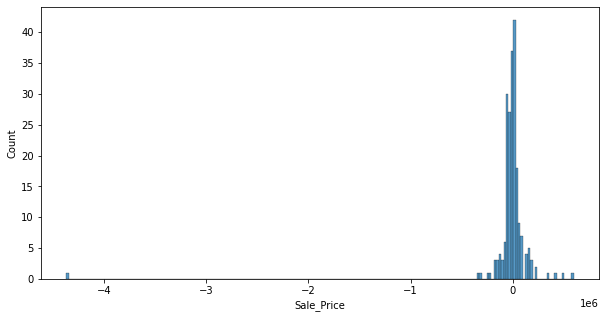

In [ ]:
# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test - y1_pred)
sns.histplot(residuals)

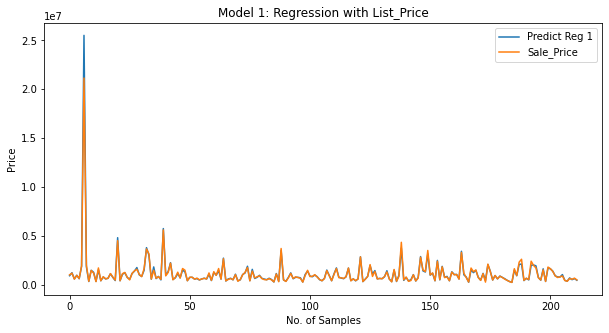

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(np.array(y1_pred))
plt.plot(np.array(y_test))
plt.title('Model 1: Regression with List_Price')
plt.ylabel('Price')
plt.xlabel('No. of Samples')
plt.legend(['Predict Reg 1', 'Sale_Price'], loc='upper right')
plt.show()

**MODEL 2:** **REGRESSION** without **List_Price**

In [ ]:
# Need to keep it here to remind what the the testing and traing features
print(X2_train.shape, X2_test.shape, y_train.shape, y_test.shape)

(4013, 46) (212, 46) (4013,) (212,)


In [ ]:
# Fit ML Regression to a training set
# Forcing intercept to be zero
from sklearn.linear_model import LinearRegression
regression2 = LinearRegression(fit_intercept=False) # False = no-intercept
regression2.fit(X2_train, y_train)

# Predicting the test result
y2_pred = regression2.predict(X2_test) # <= X has no List_Price

In [ ]:
#save Coefficent values as a DataFrame
coef2_df = pd.DataFrame(regression2.coef_, X2_train.columns, columns=['Coefficient'])
coef2_df['Coefficient'] = coef2_df['Coefficient'].map('{:,.5f}'.format)
coef2_df.head(10)

,Coefficient
SqFtTotal,879.53279
Lot_Size,-0.00069
Age,"6,500.96247"
BathsTotal,"36,268.40595"
BedsTotal,"-187,635.94393"
BathsFull,"-45,284.97722"
BathsHalf,"81,541.31618"
DOM,-418.30383
Year_Sold,"47,083.74609"
county_Alameda,"-95,141,812.41179"


**r2_score:** It drops significantly

In [ ]:
# evaluate the performance of the algorithm (MAE - MSE - RMSE)
from sklearn import metrics
from sklearn.metrics import r2_score
print('Model 2: Regression without List_Price')
#print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y2_pred))  
#print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y2_pred))  
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y2_pred)))
print('Variance -- VarScore:', metrics.explained_variance_score(y_test,y2_pred))
print("R squared(R2):", metrics.r2_score(y_test, y2_pred))

Model 2: Regression without List_Price
Root Mean Squared Error (RMSE): 912523.6454568175
Variance -- VarScore: 0.6723058986678696
R squared(R2): 0.6722142200798393


In [ ]:
#df = create a df of Sales_Price and Prediction values
result2_df = pd.DataFrame({"Sale_Price": [x for x in y_test], "Predict_Reg_2": [x for x in y2_pred]})
result2_df['Predict_Reg_2'] = result2_df['Predict_Reg_2'].map('{:,.2f}'.format)
result2_df.head(10)

,Sale_Price,Predict_Reg_2
0,1005000,"1,416,121.20"
1,1175000,"1,559,513.55"
2,565000,"639,187.61"
3,950000,"1,152,340.72"
4,625000,"526,425.80"
5,1925000,"965,161.08"
6,21150000,"10,581,912.84"
7,2000000,"1,322,725.73"
8,341000,"564,749.91"
9,1450000,"2,446,670.51"


In [ ]:
# This is the final data frame. Merge two df to match the independent variables and the predicted price
# Keep running this each model to collect prediction data for all the model
total_result_df = result1_df.merge(result2_df, how='left', on='Sale_Price', left_index=True, right_index=True)

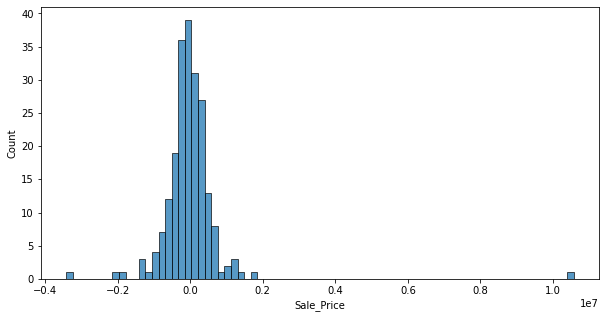

In [ ]:
# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals2 = (y_test - y2_pred)
sns.histplot(residuals2)

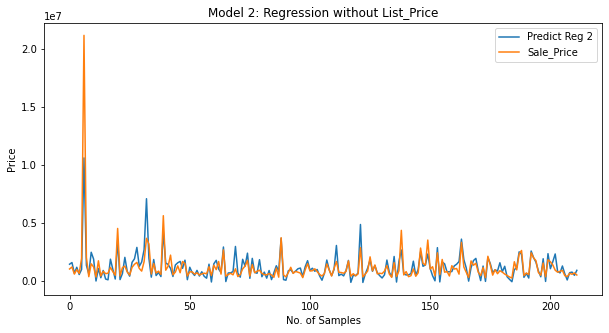

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(np.array(y2_pred))
plt.plot(np.array(y_test))
plt.title('Model 2: Regression without List_Price')
plt.ylabel('Price')
plt.xlabel('No. of Samples')
plt.legend(['Predict Reg 2', 'Sale_Price'], loc='upper right')
plt.show()

**MODEL 3:** Neural Network 1 with List_Price

In [ ]:
# Copy from Model 1: Regression 1
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4013, 47) (212, 47) (4013,) (212,)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

# Define the model - deep neural net
number_input_features = X_train.shape[1]

model3 = tf.keras.models.Sequential()

# First hidden layer

model3.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation=activation))

# Second hidden layer
model3.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation=activation))

# Third hidden layer
model3.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation=activation))

# Output layer
#  YOUR CODE GOES HERE
model3.add(tf.keras.layers.Dense(units=1, activation=activation_last))#sigmoid, softmax, tanh

# Check the structure of the model
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 15)                720       
_________________________________________________________________
dense_17 (Dense)             (None, 20)                320       
_________________________________________________________________
dense_18 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 1,261
Trainable params: 1,261
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints1/", exist_ok=True)
checkpoint_path = "checkpoints1/weights.{epoch:02d}.hdf5"

# Compile the model
#model3.compile(optimizer='Adam', loss='mean_absolute_error', metrics=['MSE'])
model3.compile(loss=loss_input, optimizer=optimizer_input, metrics=[metrics_input])# AdaGrad, AdaDelta, Adam

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    period=5,
    save_freq='epoch')

In [ ]:
# Train the model
history = model3.fit(X_train, y_train, batch_size=size_batch_no, epochs=epochs_no, callbacks=[cp_callback], validation_data=(X_test, y_test))

#history = model3.fit(X_train, y_train, batch_size=32, epochs=200, callbacks=[cp_callback], validation_data=(X_test, y_test))

Epoch 1/200
126/126 [==============================] - 1s 6ms/step - loss: 872583.9375 - MSE: 2856629567488.0000 - val_loss: 370046.6562 - val_MSE: 270677704704.0000
Epoch 2/200
126/126 [==============================] - 0s 2ms/step - loss: 108201.5859 - MSE: 383885737984.0000 - val_loss: 87829.7891 - val_MSE: 144235954176.0000
Epoch 3/200
126/126 [==============================] - 0s 2ms/step - loss: 68197.9688 - MSE: 36618166272.0000 - val_loss: 86926.8750 - val_MSE: 138602315776.0000
Epoch 4/200
126/126 [==============================] - 0s 2ms/step - loss: 68605.8203 - MSE: 41802743808.0000 - val_loss: 86335.2578 - val_MSE: 124609519616.0000
Epoch 5/200
126/126 [==============================] - 0s 2ms/step - loss: 69537.6172 - MSE: 64742322176.0000 - val_loss: 86770.4844 - val_MSE: 116121518080.0000

Epoch 00005: saving model to checkpoints1/weights.05.hdf5
Epoch 6/200
126/126 [==============================] - 0s 2ms/step - loss: 70082.2969 - MSE: 84832518144.0000 - val_loss: 878

In [ ]:
# the predict() method is used to generate predictions
y3_pred = model3.predict(X_test) # <= X has List_Price
# Export our model to HDF5 file
model3.save("NN_housing.h5")

In [ ]:
# evaluate the performance of the algorithm
from sklearn import metrics
from sklearn.metrics import r2_score
print('Model 3: Neural Network with List_Price')
#print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y3_pred))  
#print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y3_pred))  
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y3_pred)))
print('Variance -- VarScore:', metrics.explained_variance_score(y_test,y3_pred))
print("R squared(R2):", metrics.r2_score(y_test, y3_pred))

Model 3: Neural Network with List_Price
Root Mean Squared Error (RMSE): 364227.4148407067
Variance -- VarScore: 0.9477986841756235
R squared(R2): 0.9477787674347592


In [ ]:
#df = create a df of Sales_Price and Prediction values
result3_df = pd.DataFrame({"Sale_Price": [x for x in y_test], "Predict_NN_3": [x[0] for x in y3_pred]})
result3_df['Predict_NN_3'] = result3_df['Predict_NN_3'].map('{:,.2f}'.format)
result3_df.head(10)

,Sale_Price,Predict_NN_3
0,1005000,"938,110.44"
1,1175000,"1,237,749.88"
2,565000,"599,585.00"
3,950000,"977,048.06"
4,625000,"594,399.44"
5,1925000,"1,889,316.75"
6,21150000,"26,193,086.00"
7,2000000,"1,782,769.75"
8,341000,"321,130.22"
9,1450000,"1,525,661.00"


In [ ]:
# This is the final data frame. Merge two df to match the independent variables and the predicted price
total_result_df = total_result_df.merge(result3_df, how='left', on='Sale_Price', left_index=True, right_index=True)
#total_result_df.head(10)

In [ ]:
# visualizing residuals
#fig = plt.figure(figsize=(10,5))
#residuals3 = (y_test - y3_pred)
#sns.distplot(residuals)
#sns.histplot(residuals3)

# Error: Exception: Data must be 1-dimensional

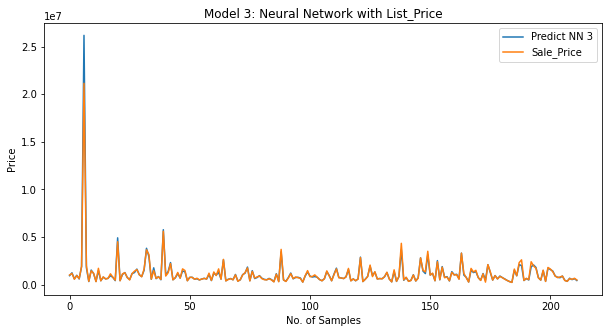

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(np.array(y3_pred))
plt.plot(np.array(y_test))
plt.title('Model 3: Neural Network with List_Price')
plt.ylabel('Price')
plt.xlabel('No. of Samples')
plt.legend(['Predict NN 3', 'Sale_Price'], loc='upper right')
plt.show()

**MODEL 4:** Neural Network 2 **without** List_Price

In [ ]:
# Need to keep it here to remind what the the testing and traing features
print(X2_train.shape, X2_test.shape, y_train.shape, y_test.shape)

(4013, 46) (212, 46) (4013,) (212,)


In [ ]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
# See inputs above

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

# Define the model - deep neural net
number_input_features2 = X2_train.shape[1] # <= pay attention here, X2 has no List_Price

model4 = tf.keras.models.Sequential()

# First hidden layer

model4.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features2, activation=activation))

# Second hidden layer
model4.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation=activation))

# Third hidden layer
model4.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation=activation))

# Output layer
model4.add(tf.keras.layers.Dense(units=1, activation=activation_last))#sigmoid, softmax, tanh

# Check the structure of the model
model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 15)                705       
_________________________________________________________________
dense_21 (Dense)             (None, 20)                320       
_________________________________________________________________
dense_22 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 11        
Total params: 1,246
Trainable params: 1,246
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints2/", exist_ok=True)
checkpoint_path2 = "checkpoints2/weights.{epoch:02d}.hdf5"

# Compile the model 4
#model4.compile(optimizer='Adam', loss='mean_absolute_error', metrics=['MSE'])
model4.compile(loss=loss_input, optimizer=optimizer_input, metrics=[metrics_input])

# Create a callback that saves the model's weights
cp_callback2 = ModelCheckpoint(
    filepath=checkpoint_path2,
    verbose=1,
    save_weights_only=True,
    period=5,
    save_freq='epoch')

In [ ]:
# Train the model
history2 = model4.fit(X2_train, y_train, batch_size=size_batch_no, epochs=epochs_no, callbacks=[cp_callback2], validation_data=(X2_test, y_test))
#history2 = model4.fit(X2_train, y_train, batch_size=32, epochs=200, callbacks=[cp_callback2], validation_data=(X2_test, y_test))

Epoch 1/200
126/126 [==============================] - 1s 3ms/step - loss: 1105909.2500 - MSE: 3445317697536.0000 - val_loss: 1128086.2500 - val_MSE: 3811138863104.0000
Epoch 2/200
126/126 [==============================] - 0s 2ms/step - loss: 1086896.0000 - MSE: 2666832855040.0000 - val_loss: 1122343.7500 - val_MSE: 3793755045888.0000
Epoch 3/200
126/126 [==============================] - 0s 2ms/step - loss: 1099069.7500 - MSE: 4181066252288.0000 - val_loss: 1102787.6250 - val_MSE: 3736233050112.0000
Epoch 4/200
126/126 [==============================] - 0s 2ms/step - loss: 1073805.5000 - MSE: 3746769141760.0000 - val_loss: 1077901.0000 - val_MSE: 3665517608960.0000
Epoch 5/200
126/126 [==============================] - 0s 2ms/step - loss: 998218.1250 - MSE: 2228133298176.0000 - val_loss: 1007914.1250 - val_MSE: 3469167820800.0000

Epoch 00005: saving model to checkpoints2/weights.05.hdf5
Epoch 6/200
126/126 [==============================] - 0s 2ms/step - loss: 889735.8750 - MSE: 203

In [ ]:
# Export our model to HDF5 file
model4.save("NN2_housing.h5")

# the predict() method is used to generate predictions
y4_pred = model4.predict(X2_test) # <= X2 has no List_Price

**Note: ** R-square drops significantly

In [ ]:
# evaluate the performance of the algorithm (MAE - MSE - RMSE)
from sklearn import metrics
print('Model 4: Neural Network without List_Price')
#print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y4_pred))  
#print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y4_pred))  
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y4_pred)))
print('Variance -- VarScore:', metrics.explained_variance_score(y_test,y4_pred))
print("R squared(R2):", metrics.r2_score(y_test, y4_pred))

Model 4: Neural Network without List_Price
Root Mean Squared Error (RMSE): 1097673.156692757
Variance -- VarScore: 0.537689883623117
R squared(R2): 0.5257056589610347


In [ ]:
#df = create a df of Sales_Price and Prediction values
result4_df = pd.DataFrame({"Sale_Price": [x for x in y_test], "Predict_NN_4": [x[0] for x in y4_pred]})
result4_df['Predict_NN_4'] = result4_df['Predict_NN_4'].map('{:,.2f}'.format)
result4_df.head(10)

,Sale_Price,Predict_NN_4
0,1005000,"893,362.38"
1,1175000,"1,406,229.62"
2,565000,"723,752.31"
3,950000,"998,141.25"
4,625000,"598,905.44"
5,1925000,"940,863.06"
6,21150000,"7,940,968.00"
7,2000000,"1,234,092.62"
8,341000,"761,218.81"
9,1450000,"1,712,736.12"


In [ ]:
# This is the final data frame of all the model prediction
total_result_df = total_result_df.merge(result4_df, how='left', on='Sale_Price', left_index=True, right_index=True)
#total_result_df.head(10)

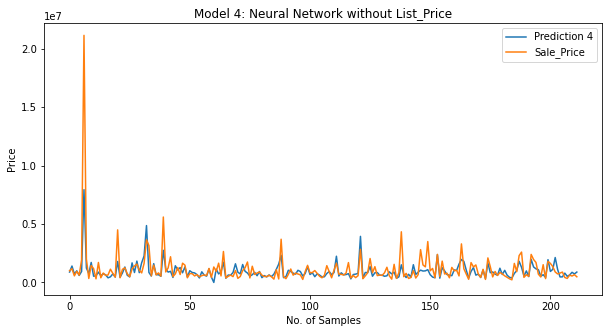

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(np.array(y4_pred))
plt.plot(np.array(y_test))
plt.title('Model 4: Neural Network without List_Price')
plt.ylabel('Price')
plt.xlabel('No. of Samples')
plt.legend(['Prediction 4', 'Sale_Price'], loc='upper right')
plt.show()

In [ ]:
print("SUMMARY OF R2_SCORE"'\n')
print("Model 1: Regression with List_Price:", metrics.r2_score(y_test, y1_pred))
print('')
print("Model 2: Regression withOUT List_Price:", metrics.r2_score(y_test, y2_pred))
print('')
print("Model 3: Neural Network with List_Price:", metrics.r2_score(y_test, y3_pred))
print('')
print("Model 4: Neural Network withOUT List_Price:", metrics.r2_score(y_test, y4_pred))

SUMMARY OF R2_SCORE

Model 1: Regression with List_Price: 0.9605332854433306

Model 2: Regression withOUT List_Price: 0.6722142200798393

Model 3: Neural Network with List_Price: 0.9477787674347592

Model 4: Neural Network withOUT List_Price: 0.5257056589610347


**BEGIN Random Forest**

In [ ]:
# Need to keep it here to remind what the the testing and traing features
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)# <= X_tranin includes "List_Price"
print(X2_train.shape, X2_test.shape, y_train.shape, y_test.shape)# <= X2_train excludes "List_Price"

(4013, 47) (212, 47) (4013,) (212,)
(4013, 46) (212, 46) (4013,) (212,)


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

In [ ]:
# Evaluate the model
model5 = RandomForestRegressor(n_estimators = epochs_no, max_depth = 5, min_samples_leaf= 5, max_features = 'sqrt')  # using GridSearch
model5 = RandomForestRegressor()
model5.fit(X_train, y_train) # gets the parameters for the rfr model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# the predict() method is used to generate predictions
y5_pred = model5.predict(X_test) # <= X2 has no List_Price

In [ ]:
# evaluate the performance of the algorithm (MAE - MSE - RMSE)
print('Model 5: Random Forest with List_Price')
#print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y4_pred))  
#print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y4_pred))  
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y5_pred)))
print('Variance -- VarScore:', metrics.explained_variance_score(y_test,y5_pred))
print("R squared(R2):", metrics.r2_score(y_test, y5_pred))

Model 5: Random Forest with List_Price
Root Mean Squared Error (RMSE): 249951.11179597076
Variance -- VarScore: 0.975511226730619
R squared(R2): 0.9754069721764181


In [ ]:
#df = create a df of Sales_Price and Prediction values
result5_df = pd.DataFrame({"Sale_Price": [x for x in y_test], "Predict_rfr_5": [x for x in y5_pred]})
result5_df['Predict_rfr_5'] = result5_df['Predict_rfr_5'].map('{:,.2f}'.format)
result5_df.head(10)

,Sale_Price,Predict_rfr_5
0,1005000,"940,514.20"
1,1175000,"1,186,084.00"
2,565000,"569,890.00"
3,950000,"940,118.68"
4,625000,"599,575.52"
5,1925000,"1,965,106.00"
6,21150000,"17,837,550.00"
7,2000000,"1,944,670.90"
8,341000,"311,230.00"
9,1450000,"1,521,242.42"


In [ ]:
# This is the final data frame of all the model prediction
total_result_df = total_result_df.merge(result5_df, how='left', on='Sale_Price', left_index=True, right_index=True)
#total_result_df.head(10)

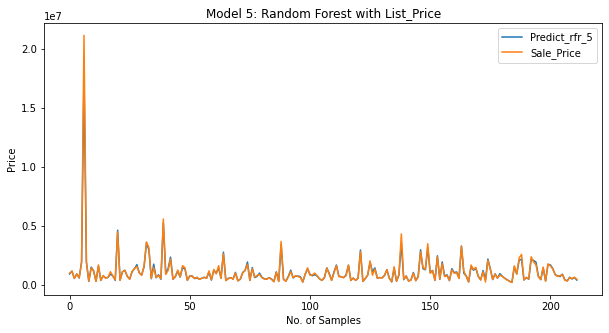

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(np.array(y5_pred))
plt.plot(np.array(y_test))
plt.title('Model 5: Random Forest with List_Price')
plt.ylabel('Price')
plt.xlabel('No. of Samples')
plt.legend(['Predict_rfr_5', 'Sale_Price'], loc='upper right')
plt.show()

In [ ]:
# Random forest determined feature importances
model5.feature_importances_

array([3.13473350e-03, 3.29143497e-03, 4.29868676e-03, 3.71513811e-04,
       3.23787222e-04, 5.81235704e-04, 4.05606571e-04, 2.22847661e-03,
       2.11039480e-06, 9.81351067e-01, 5.36151786e-04, 1.67350787e-07,
       1.50245713e-06, 1.41700145e-04, 4.74920450e-06, 2.98230031e-07,
       2.22009892e-06, 2.23802566e-04, 6.63492938e-07, 3.01404776e-04,
       2.92299911e-07, 8.40699132e-07, 5.25467629e-06, 3.64716986e-06,
       1.63697751e-06, 2.48468766e-04, 1.13651723e-06, 1.49386957e-05,
       9.51471837e-06, 1.23107946e-05, 2.28603753e-07, 9.78812361e-06,
       4.89042643e-05, 1.43533015e-04, 7.31847391e-06, 1.20816094e-05,
       1.89364753e-03, 1.34741817e-07, 3.14531040e-04, 1.37079173e-05,
       2.09908703e-06, 3.75288429e-05, 2.02006638e-06, 2.51005628e-06,
       5.76398103e-06, 6.10300954e-06, 7.45769542e-07])

In [ ]:
importance = model5.feature_importances_

# map feature importance values to the features
feature_importances = zip(importance, X.columns)
#list(feature_importances)

sorted_feature_importances = sorted(feature_importances, reverse = True)
#print(sorted_feature_importances)

top_15_predictors = sorted_feature_importances[0:10]
values = [value for value, predictors in top_15_predictors]
predictors = [predictors for value, predictors in top_15_predictors]
print(predictors)

['List_Price', 'Age', 'Lot_Size', 'SqFtTotal', 'DOM', 'county_San Mateo', 'BathsFull', 'county_Alameda', 'BathsHalf', 'BathsTotal']


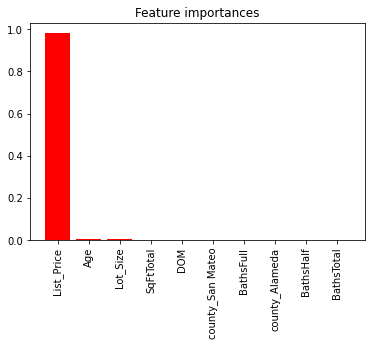

In [ ]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);

**Model 6** Random Forest without List_Price

In [ ]:
# Evaluate the model
model6 = RandomForestRegressor(n_estimators = epochs_no, max_depth = 5, min_samples_leaf= 5, max_features = 'sqrt')  # using GridSearch
model6 = RandomForestRegressor()
model6.fit(X2_train, y_train) # gets the parameters for the rfr model
# the predict() method is used to generate predictions
y6_pred = model6.predict(X2_test) # <= X2 has no List_Price

In [ ]:
# evaluate the performance of the algorithm (MAE - MSE - RMSE)
print('Model 6: Random Forest without List_Price')
#print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y4_pred))  
#print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y4_pred))  
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y6_pred)))
print('Variance -- VarScore:', metrics.explained_variance_score(y_test,y6_pred))
print("R squared(R2):", metrics.r2_score(y_test, y6_pred))

Model 6: Random Forest without List_Price
Root Mean Squared Error (RMSE): 884946.8904190123
Variance -- VarScore: 0.6917448461215323
R squared(R2): 0.6917264451526179


In [ ]:
#df = create a df of Sales_Price and Prediction values
result6_df = pd.DataFrame({"Sale_Price": [x for x in y_test], "Predict_rfr_6": [x for x in y6_pred]})
result6_df['Predict_rfr_6'] = result6_df['Predict_rfr_6'].map('{:,.2f}'.format)
result6_df.head(10)

,Sale_Price,Predict_rfr_6
0,1005000,"1,440,661.42"
1,1175000,"1,479,167.00"
2,565000,"508,560.00"
3,950000,"1,035,472.50"
4,625000,"688,514.00"
5,1925000,"843,236.56"
6,21150000,"11,352,300.00"
7,2000000,"1,475,541.70"
8,341000,"627,354.00"
9,1450000,"1,592,350.00"


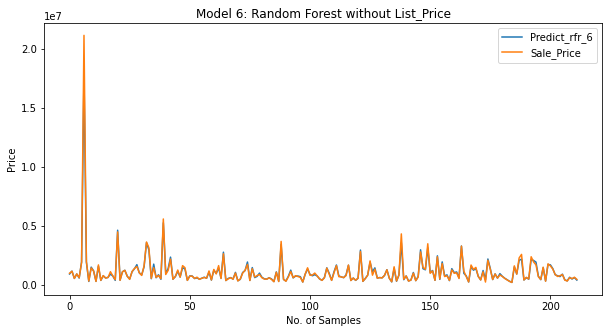

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(np.array(y5_pred))
plt.plot(np.array(y_test))
plt.title('Model 6: Random Forest without List_Price')
plt.ylabel('Price')
plt.xlabel('No. of Samples')
plt.legend(['Predict_rfr_6', 'Sale_Price'], loc='upper right')
plt.show()

['SqFtTotal', 'Age', 'Lot_Size', 'county_Santa Barbara', 'county_San Luis Obispo', 'county_Madera', 'DOM', 'BathsFull', 'BathsTotal', 'BedsTotal']


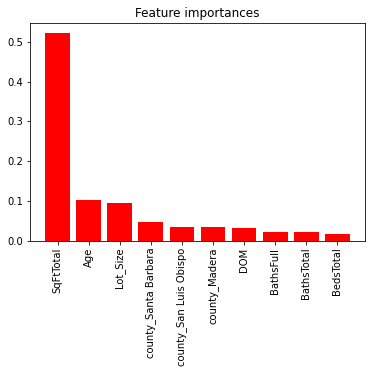

In [ ]:
# Random forest determined feature importances
model6.feature_importances_
importance = model6.feature_importances_

# map feature importance values to the features
feature_importances = zip(importance, X.columns)
#list(feature_importances)

sorted_feature_importances = sorted(feature_importances, reverse = True)
#print(sorted_feature_importances)

top_15_predictors = sorted_feature_importances[0:10]
values = [value for value, predictors in top_15_predictors]
predictors = [predictors for value, predictors in top_15_predictors]
print(predictors)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values, color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);

**Final Report**

In [ ]:
print("SUMMARY OF R2_SCORE"'\n')
print("Model 1: Regression with List_Price:", metrics.r2_score(y_test, y1_pred))
print('')
print("Model 2: Regression withOUT List_Price:", metrics.r2_score(y_test, y2_pred))
print('')
print("Model 3: Neural Network with List_Price:", metrics.r2_score(y_test, y3_pred))
print('')
print("Model 4: Neural Network withOUT List_Price:", metrics.r2_score(y_test, y4_pred))
print('')
print("Model 5: Random Forest with List_Price:", metrics.r2_score(y_test, y5_pred))
print('')
print("Model 6: Random Forest withOUT List_Price:", metrics.r2_score(y_test, y6_pred))

SUMMARY OF R2_SCORE

Model 1: Regression with List_Price: 0.9605332854433306

Model 2: Regression withOUT List_Price: 0.6722142200798393

Model 3: Neural Network with List_Price: 0.9477787674347592

Model 4: Neural Network withOUT List_Price: 0.5257056589610347

Model 5: Random Forest with List_Price: 0.9754069721764181

Model 6: Random Forest withOUT List_Price: 0.6917264451526179


In [ ]:

data = {
"Model":["Model 1: Regression with List_Price", "Model 2: Regression withOUT List_Price","Model 3: Neural Network with List_Price",
         "Model 4: Neural Network withOUT List_Price","Model 5: Random Forest with List_Price","Model 6: Random Forest withOUT List_Price"],
"R2_score":[metrics.r2_score(y_test, y1_pred),metrics.r2_score(y_test, y2_pred),metrics.r2_score(y_test, y3_pred),metrics.r2_score(y_test, y4_pred),
            metrics.r2_score(y_test, y5_pred),metrics.r2_score(y_test, y6_pred)]};

r2score_df = pd.DataFrame(data=data);
r2score_df

,Model,R2_score
0,Model 1: Regression with List_Price,0.960533
1,Model 2: Regression withOUT List_Price,0.672214
2,Model 3: Neural Network with List_Price,0.947779
3,Model 4: Neural Network withOUT List_Price,0.525706
4,Model 5: Random Forest with List_Price,0.975407
5,Model 6: Random Forest withOUT List_Price,0.691726


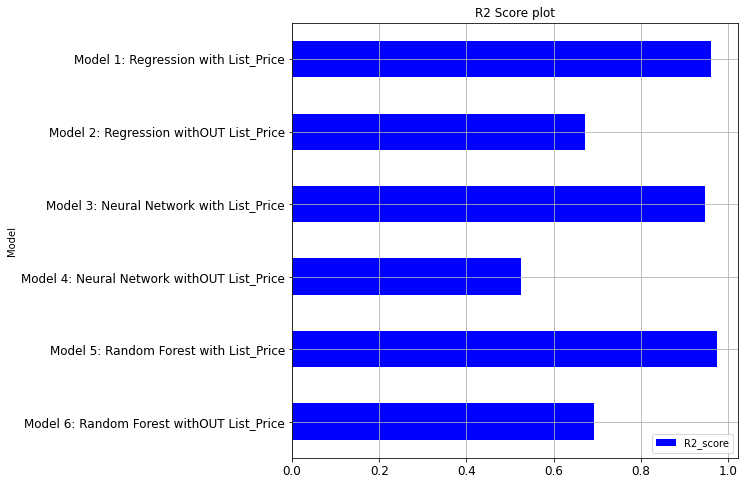

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plot
# Reserve the row order
r2score_df = r2score_df.iloc[::-1]
#datafram plot barh
r2score_df.plot.barh(figsize = (8,8), fontsize=12, x="Model", title="R2 Score plot", colormap='winter', grid=True, sort_columns=True)
plot.show();

In [ ]:
# This is the final data frame of all the model prediction
total_result_df = total_result_df.merge(result6_df, how='left', on='Sale_Price', left_index=True, right_index=True)
total_result_df.head(10)

,Sale_Price,Predict_Reg_1,Predict_Reg_2,Predict_NN_3,Predict_NN_4,Predict_rfr_5,Predict_rfr_6
0,1005000,"913,281.32","1,416,121.20","938,110.44","893,362.38","940,514.20","1,440,661.42"
1,1175000,"1,219,022.44","1,559,513.55","1,237,749.88","1,406,229.62","1,186,084.00","1,479,167.00"
2,565000,"587,771.36","639,187.61","599,585.00","723,752.31","569,890.00","508,560.00"
3,950000,"959,388.14","1,152,340.72","977,048.06","998,141.25","940,118.68","1,035,472.50"
4,625000,"608,544.68","526,425.80","594,399.44","598,905.44","599,575.52","688,514.00"
5,1925000,"1,872,278.90","965,161.08","1,889,316.75","940,863.06","1,965,106.00","843,236.56"
6,21150000,"25,521,630.17","10,581,912.84","26,193,086.00","7,940,968.00","17,837,550.00","11,352,300.00"
7,2000000,"1,830,298.75","1,322,725.73","1,782,769.75","1,234,092.62","1,944,670.90","1,475,541.70"
8,341000,"321,158.59","564,749.91","321,130.22","761,218.81","311,230.00","627,354.00"
9,1450000,"1,469,391.98","2,446,670.51","1,525,661.00","1,712,736.12","1,521,242.42","1,592,350.00"


**END of the End!**